(256, 258, 3)
(256, 258)
16
0
1
2
3
4
5
6
7
3
3


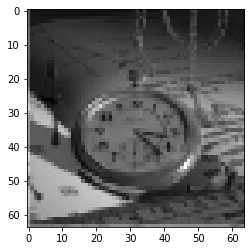

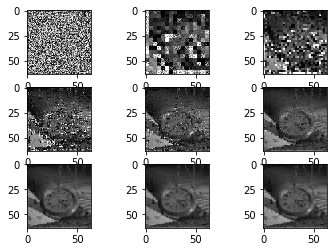

0/16 ; 0/16
0/16 ; 1/16
0/16 ; 2/16
0/16 ; 3/16
0/16 ; 4/16
0/16 ; 5/16
0/16 ; 6/16
0/16 ; 7/16
0/16 ; 8/16
0/16 ; 9/16
0/16 ; 10/16
0/16 ; 11/16
0/16 ; 12/16


C:\Users\manug\AppData\Local\Temp\ipykernel_1048\235915689.py:51: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, _, _, _ = np.linalg.lstsq(A, b)


0/16 ; 13/16
0/16 ; 14/16
0/16 ; 15/16
1/16 ; 0/16
1/16 ; 1/16
1/16 ; 2/16
1/16 ; 3/16
1/16 ; 4/16
1/16 ; 5/16
1/16 ; 6/16
1/16 ; 7/16
1/16 ; 8/16
1/16 ; 9/16
1/16 ; 10/16
1/16 ; 11/16
1/16 ; 12/16
1/16 ; 13/16
1/16 ; 14/16
1/16 ; 15/16
2/16 ; 0/16
2/16 ; 1/16
2/16 ; 2/16
2/16 ; 3/16
2/16 ; 4/16
2/16 ; 5/16
2/16 ; 6/16
2/16 ; 7/16
2/16 ; 8/16
2/16 ; 9/16
2/16 ; 10/16
2/16 ; 11/16
2/16 ; 12/16
2/16 ; 13/16
2/16 ; 14/16
2/16 ; 15/16
3/16 ; 0/16
3/16 ; 1/16
3/16 ; 2/16
3/16 ; 3/16
3/16 ; 4/16
3/16 ; 5/16
3/16 ; 6/16
3/16 ; 7/16
3/16 ; 8/16
3/16 ; 9/16
3/16 ; 10/16
3/16 ; 11/16
3/16 ; 12/16
3/16 ; 13/16
3/16 ; 14/16
3/16 ; 15/16
4/16 ; 0/16
4/16 ; 1/16
4/16 ; 2/16
4/16 ; 3/16
4/16 ; 4/16
4/16 ; 5/16
4/16 ; 6/16
4/16 ; 7/16
4/16 ; 8/16
4/16 ; 9/16
4/16 ; 10/16
4/16 ; 11/16
4/16 ; 12/16
4/16 ; 13/16
4/16 ; 14/16
4/16 ; 15/16
5/16 ; 0/16
5/16 ; 1/16
5/16 ; 2/16
5/16 ; 3/16
5/16 ; 4/16
5/16 ; 5/16
5/16 ; 6/16
5/16 ; 7/16
5/16 ; 8/16
5/16 ; 9/16
5/16 ; 10/16
5/16 ; 11/16
5/16 ; 12/16
5/16 ; 13/

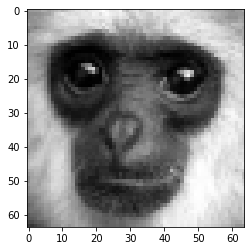

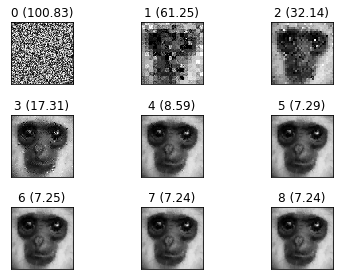

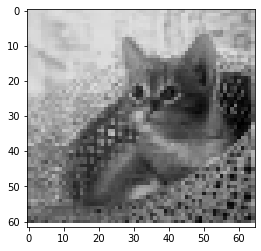

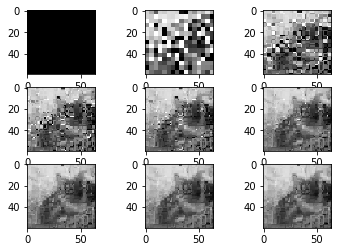

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from scipy import optimize
from PIL import Image
import numpy as np
import math

# Transformations

def reduzir(img, factor):
    result = np.zeros((img.shape[0] // factor, img.shape[1] // factor)) #divide o tamanho da imagem por um fator
    for i in range(result.shape[0]): #percorrer através das novas linhas da imagem
        for j in range(result.shape[1]):  #percorrer através das novas colunas da imagem
            result[i,j] = np.mean(img[i*factor:(i+1)*factor,j*factor:(j+1)*factor])
    return result

def rotacionar(imagem, divisao):
  l,c = np.shape(imagem)
  alpha = np.pi / (-divisao) 
  ls, cs = int(l * np.sqrt(2)), int(c * np.sqrt(2))
  imagem_rot = np.zeros((ls, cs), dtype=np.uint8)
  for i in range(ls):
      for j in range(cs):
        cx = j - (ls / 2)
        cy = i - (cs / 2)
        
        new_x = int( cx * np.cos(alpha) + cy * np.sin(alpha) + l / 2)
        new_y = int(-cx * np.sin(alpha) + cy * np.cos(alpha) + c / 2)
        
        # Pegar apenas a imagem original.
        if 0 <= new_x < c and 0 <= new_y < l:
            imagem_rot[i, j] = imagem[new_y, new_x]


  largura = ((ls - l)//2)

  altura = ((cs - c)//2)


  mask = np.zeros(shape= imagem_rot.shape, dtype=np.uint8)
  mask[largura:ls - largura,altura:cs-altura] = 255

  img_mask =  imagem_rot & mask
  img_mask = img_mask[largura:largura+imagem.shape[0],altura:altura+imagem.shape[1]]


  return img_mask

def flip(img, direcao):
    return img[::direcao,:]

def aplica_transformacoes(img, direcao, angulo, contrast=1.0, brightness=0.0):
    return contrast*rotacionar(flip(img, direcao), angulo) + brightness

def find_contrast_and_brightness2(D, S):
    #funcao que ajusta o contraste e o brilho dos blocos
    A = np.concatenate((np.ones((S.size, 1)), np.reshape(S, (S.size, 1))), axis=1)
    b = np.reshape(D, (D.size,))
    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    return x[1], x[0]


def generate_all_transformed_blocks(img, source_size, destination_size, step):
    factor = source_size // destination_size
    transformed_blocks = []
    for k in range((img.shape[0] - source_size) // step + 1):
        for l in range((img.shape[1] - source_size) // step + 1):
            # A partir das coordenadas do bloco dominio extraimos o bloco molde
            S = reduzir(img[k*step:k*step+source_size,l*step:l*step+source_size], factor)
            # Com o bloco molde extraido geramos todas as combinaçoes da trasnformações geometricas possíveis
            for direcao, angulo in combinacoes:
                transformed_blocks.append((k, l, direcao, angulo, aplica_transformacoes(S, direcao, angulo))) #coloca numa lista todos os blocos com direcao e angulos possiveis 
    return transformed_blocks

def compress(img, source_size, destination_size, step):
    transformations = []
    transformed_blocks = generate_all_transformed_blocks(img, source_size, destination_size, step)
    i_count = img.shape[0] // destination_size
    j_count = img.shape[1] // destination_size
    for i in range(i_count):
        transformations.append([])
        for j in range(j_count):
            transformations[i].append(None)
            min_d = float('inf')
            # Extraindo bloco de dominio para comparação
            D = img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size]
            # É testado todas as possiveis transformaçoes geometricas
            for k, l,direcao, angulo, S in transformed_blocks:
                contrast, brightness = find_contrast_and_brightness2(D, S)
                S = contrast*S + brightness
                d = np.sum(np.square(D - S))
                if d < min_d:
                    min_d = d
                    transformations[i][j] = (k, l, direcao, angulo, contrast, brightness)
    return transformations

def decompress(transformations, source_size, destination_size, step, nb_iter=8):
    factor = source_size // destination_size
    height = len(transformations) * destination_size
    width = len(transformations[0]) * destination_size
    iterations = [np.zeros((height, width))]
    cur_img = np.zeros((height, width))
    for i_iter in range(nb_iter):
        for i in range(len(transformations)):
            for j in range(len(transformations[i])):
                # Aplicando a transformacao dada pelo array de trasformacao 
                k, l, flip, angulo, contrast, brightness = transformations[i][j]
                S = reduzir(iterations[-1][k*step:k*step+source_size,l*step:l*step+source_size], factor)
                D = aplica_transformacoes(S, flip, angulo, contrast, brightness)
                cur_img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size] = D
        iterations.append(cur_img)
        cur_img = np.zeros((height, width))
    return iterations

# Plot

def plot_iterations(iterations):
    # Configuracao do plot
    plt.figure()
    nb_row = math.ceil(np.sqrt(len(iterations)))
    nb_cols = nb_row
    # Plot
    for i, img in enumerate(iterations):
        plt.subplot(nb_row, nb_cols, i+1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
        
    

# Parametros

direcoes = [1, -1]
angulos = [0.5, 2, 1, -2]
#todas as combinacoes possiveis entre direcao e angulo 
combinacoes = [[direcao, angulo] for direcao in direcoes for angulo in angulos] 

path1 = "./relogio.png"
path2 = "./borboleta.png"
path3 = "./gato.png"

def comprimir(path):
  img = Image.open(path)    
  img_array = np.array(img)
  img_gray = np.average(img_array[:, :, :3], axis=2).astype(np.uint8)
  img_red = reduzir(img_gray, 4)
  plt.figure()
  plt.imshow(img_red, cmap='gray', interpolation='none')
  transformations = compress(img_red, 8, 4, 8)
  return transformations

def descomprimir(img):
    iterations = decompress(img, 8, 4, 8)
    return iterations

img_comprimida = comprimir(path3)
img_descomprimida = descomprimir(img_comprimida)

plot_iterations(img_descomprimida)
plt.show()